#### 필요한 패키지 설치

In [1]:
!pip install bs4


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

In [3]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

In [4]:
class Config:
    # define the base path to the *original* input dataset and then use
    # the base path to derive the image and annotations directories
    ORIG_BASE_PATH = "raccoons"
    ORIG_IMAGES = os.path.sep.join([ORIG_BASE_PATH, "images"])
    ORIG_ANNOTS = os.path.sep.join([ORIG_BASE_PATH, "annotations"])

    # define the base path to the *new* dataset after running our dataset
    # builder scripts and then use the base path to derive the paths to
    # our output class label directories
    BASE_PATH = "dataset"
    POSITVE_PATH = os.path.sep.join([BASE_PATH, "raccoon"])
    NEGATIVE_PATH = os.path.sep.join([BASE_PATH, "no_raccoon"])

    # define the number of max proposals used when running selective
    # search for (1) gathering training data and (2) performing inference
    MAX_PROPOSALS = 2000
    MAX_PROPOSALS_INFER = 200

    # define the maximum number of positive and negative images to be
    # generated from each image
    MAX_POSITIVE = 30
    MAX_NEGATIVE = 10

    # initialize the input dimensions to the network
    INPUT_DIMS = (224, 224)
    # define the path to the output model and label binarizer
    MODEL_PATH = "raccoon_detector.h5"
    ENCODER_PATH = "label_encoder.pickle"

    # define the minimum probability required for a positive prediction
    # (used to filter out false-positive predictions)
    MIN_PROBA = 0.99

# instantiate our Config object
config = Config()

In [25]:
def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [26]:
boxA = np.array([100,100,299,299])
boxB = np.array([200,200,399,399])
iou = compute_iou(boxA, boxB)
print(iou)

0.14285714285714285


In [27]:
boxA = np.array([0,0,199,199])
boxB = np.array([300,0,499,199])
iou = compute_iou(boxA, boxB)
print(iou)

0.0


In [28]:
boxA = np.array([0,0,199,199])
boxB = np.array([10,10,209,209])
iou = compute_iou(boxA, boxB)
print(iou)

0.8223234624145785


In [6]:
# loop over the output positive and negative directories
for dirPath in (config.POSITVE_PATH, config.NEGATIVE_PATH):
    # if the output directory does not exist yet, create it
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

# grab all image paths in the input images directory
imagePaths = list(paths.list_images(config.ORIG_IMAGES))

# initialize the total number of positive and negative images we have
# saved to disk so far
totalPositive = 0
totalNegative = 0

In [8]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # show a progress report
    print("[INFO] processing image {}/{}...".format(i + 1,
        len(imagePaths)))

    # extract the filename from the file path and use it to derive
    # the path to the XML annotation file
    filename = imagePath.split(os.path.sep)[-1]
    filename = filename[:filename.rfind(".")]
    annotPath = os.path.sep.join([config.ORIG_ANNOTS,
        "{}.xml".format(filename)])

    # load the annotation file, build the soup, and initialize our
    # list of ground-truth bounding boxes
    contents = open(annotPath).read()
    soup = BeautifulSoup(contents, "html.parser")
    gtBoxes = []

    # extract the image dimensions
    w = int(soup.find("width").string)
    h = int(soup.find("height").string)

    # loop over all 'object' elements
    for o in soup.find_all("object"):
        # extract the label and bounding box coordinates
        label = o.find("name").string
        xMin = int(o.find("xmin").string)
        yMin = int(o.find("ymin").string)
        xMax = int(o.find("xmax").string)
        yMax = int(o.find("ymax").string)

        # truncate any bounding box coordinates that may fall
        # outside the boundaries of the image
        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(w, xMax)
        yMax = min(h, yMax)

        # update our list of ground-truth bounding boxes
        gtBoxes.append((xMin, yMin, xMax, yMax))

    # load the input image from disk
    image = cv2.imread(imagePath)

    # run selective search on the image and initialize our list of
    # proposed boxes
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    proposedRects= []

    # loop over the rectangles generated by selective search
    for (x, y, w, h) in rects:
        # convert our bounding boxes from (x, y, w, h) to (startX,
        # startY, startX, endY)
        proposedRects.append((x, y, x + w, y + h))

    # initialize counters used to count the number of positive and
    # negative ROIs saved thus far
    positiveROIs = 0
    negativeROIs = 0

    # loop over the maximum number of region proposals
    for proposedRect in proposedRects[:config.MAX_PROPOSALS]:
        # unpack the proposed rectangle bounding box
        (propStartX, propStartY, propEndX, propEndY) = proposedRect

        # loop over the ground-truth bounding boxes
        for gtBox in gtBoxes:
            # compute the intersection over union between the two
            # boxes and unpack the ground-truth bounding box
            iou = compute_iou(gtBox, proposedRect)
            (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox

            # initialize the ROI and output path
            roi = None
            outputPath = None

            # check to see if the IOU is greater than 70% *and* that
            # we have not hit our positive count limit
            if iou > 0.7 and positiveROIs <= config.MAX_POSITIVE:
                # extract the ROI and then derive the output path to
                # the positive instance
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalPositive)
                outputPath = os.path.sep.join([config.POSITVE_PATH,
                    filename])

                # increment the positive counters
                positiveROIs += 1
                totalPositive += 1

            # determine if the proposed bounding box falls *within*
            # the ground-truth bounding box
            fullOverlap = propStartX >= gtStartX
            fullOverlap = fullOverlap and propStartY >= gtStartY
            fullOverlap = fullOverlap and propEndX <= gtEndX
            fullOverlap = fullOverlap and propEndY <= gtEndY

            # check to see if there is not full overlap *and* the IoU
            # is less than 5% *and* we have not hit our negative
            # count limit
            if not fullOverlap and iou < 0.05 and \
                negativeROIs <= config.MAX_NEGATIVE:
                # extract the ROI and then derive the output path to
                # the negative instance
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.png".format(totalNegative)
                outputPath = os.path.sep.join([config.NEGATIVE_PATH,
                    filename])

                # increment the negative counters
                negativeROIs += 1
                totalNegative += 1

            # check to see if both the ROI and output path are valid
            if roi is not None and outputPath is not None:
                # resize the ROI to the input dimensions of the CNN
                # that we'll be fine-tuning, then write the ROI to
                # disk
                roi = cv2.resize(roi, config.INPUT_DIMS,
                    interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

In [9]:
args = {
    "plot": "plot.png"
}

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 3
BS = 32

In [10]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class labels
print("[INFO] loading images...")
imagePaths = list(paths.list_images(config.BASE_PATH))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=config.INPUT_DIMS)
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [11]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [12]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/3
25/25 [==============================] - 25s 897ms/step - loss: 0.5729 - accuracy: 0.7625 - val_loss: 0.2566 - val_accuracy: 0.9900
Epoch 2/3
25/25 [==============================] - 23s 926ms/step - loss: 0.2257 - accuracy: 0.9675 - val_loss: 0.1093 - val_accuracy: 0.9950
Epoch 3/3
25/25 [==============================] - 21s 840ms/step - loss: 0.1210 - accuracy: 0.9875 - val_loss: 0.0659 - val_accuracy: 0.9950


In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

  no_raccoon       1.00      0.99      0.99       100
     raccoon       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [15]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(config.MODEL_PATH, save_format="h5")

# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(config.ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...
[INFO] saving label encoder...


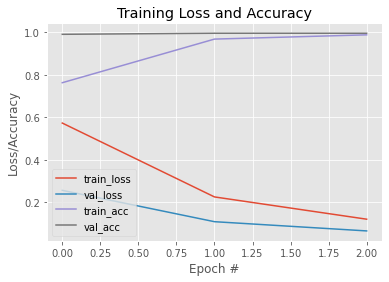

In [16]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

In [17]:
args = {
    "image": "images/raccoon_02.jpg"
}

In [18]:
# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(config.MODEL_PATH)
lb = pickle.loads(open(config.ENCODER_PATH, "rb").read())

# load the input image from disk
image = cv2.imread(args["image"])
image = imutils.resize(image, width=500)

# run selective search on the image to generate bounding box proposal
# regions
print("[INFO] running selective search...")
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

[INFO] loading model and label binarizer...
[INFO] running selective search...


In [19]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []

# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:config.MAX_PROPOSALS_INFER]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, config.INPUT_DIMS,
        interpolation=cv2.INTER_CUBIC)

    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)

    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))

In [20]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print("[INFO] proposal shape: {}".format(proposals.shape))

# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = model.predict(proposals)

[INFO] proposal shape: (200, 224, 224, 3)
[INFO] classifying proposals...


In [21]:
# find the index of all predictions that are positive for the
# "raccoon" class
print("[INFO] applying NMS...")
labels = lb.classes_[np.argmax(proba, axis=1)]
idxs = np.where(labels == "raccoon")[0]

# use the indexes to extract all bounding boxes and associated class
# label probabilities associated with the "raccoon" class
boxes = boxes[idxs]
proba = proba[idxs][:, 1]

# further filter indexes by enforcing a minimum prediction
# probability be met
idxs = np.where(proba >= config.MIN_PROBA)
boxes = boxes[idxs]
proba = proba[idxs]

[INFO] applying NMS...


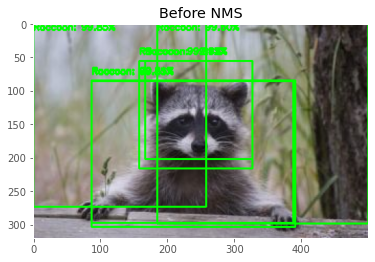

In [22]:
# clone the original image so that we can draw on it
clone = image.copy()

# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text= "Raccoon: {:.2f}%".format(prob * 100)
    cv2.putText(clone, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

# show the output after *before* running NMS
plt_imshow("Before NMS", clone)

In [23]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return the indexes of only the bounding boxes to keep
    return pick

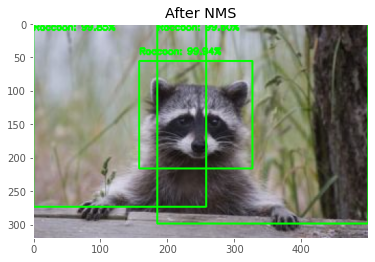

In [24]:
# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba)

# loop over the bounding box indexes
for i in boxIdxs:
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = boxes[i]
    cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text= "Raccoon: {:.2f}%".format(proba[i] * 100)
    cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

# show the output image *after* running NMS
plt_imshow("After NMS", image)